In [1]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona as fio
import shapely as shp  
#import gdal as gd
from owslib.wfs import WebFeatureService

import requests
import geojson as gs
import json

In [2]:
# read in point data
df = pd.read_csv("../data/alt/gis/point/ar_samples.csv")

# read in geo jsons

gdf_geol = gpd.read_file("../data/alt/gis/polygon/geology.geojson")
gdf_faults = gpd.read_file("../data/alt/gis/polygon/geofaults.geojson")
gdf_landuse = gpd.read_file("../data/alt/gis/polygon/landuse.geojson")
gdf_cropland = gpd.read_file("../data/alt/gis/polygon/cropland.geojson")
gdf_cnty = gpd.read_file("../data/alt/gis/polygon/county.geojson")
gdf_mines = gpd.read_file("../data/alt/gis/point/mines.geojson")

In [3]:
# function to print the name and crs for each geodataframe above

def print_crs():
    print('geology crs:', gdf_geol.crs)
    print('faults crs:', gdf_faults.crs)
    print('landuse crs:', gdf_landuse.crs)
    print('cropland crs:', gdf_cropland.crs)
    print('county crs:', gdf_cnty.crs)
    print('mines crs:', gdf_mines.crs)
    print('sample data crs:', ar.crs)

In [5]:
# Create two point datasets, one for points that got their XY coordinates from the merge with permit data, 
# and one for points that got their XY from google geocoding. This is because they likely have different coordinate systems.
# Once they have the same coordinate system, the geoocoded points can be merged with the permit points.

ar = df[df['X'].notnull()]
geocoded = df[df['X'].isnull()]

# convert both to geodataframes

ar = gpd.GeoDataFrame(ar, geometry=gpd.points_from_xy(ar.X, ar.Y), crs = "EPSG:4269")

# specify the coordinate system for google maps output (WGS84)
geocoded = gpd.GeoDataFrame(geocoded, geometry=gpd.points_from_xy(geocoded.geoX, geocoded.geoY), crs="EPSG:4326")

# change to NAD83
geocoded = geocoded.to_crs("EPSG:4269")


# concatenate the two geo dataframes
ar = pd.concat([ar, geocoded], ignore_index=True)


# check the length of the merged dataset
len(ar)

1687

<Axes: >

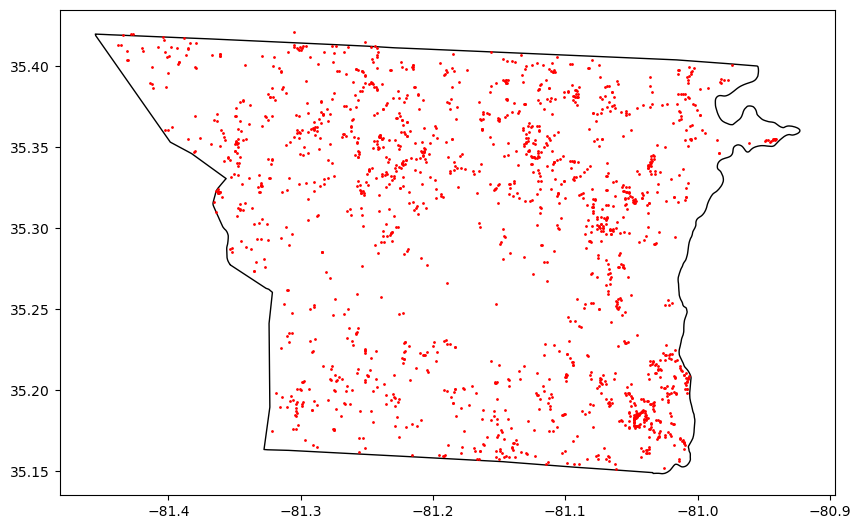

In [6]:
# check all points within county
# by plotting county border and ar points
# using subplots

fig, ax = plt.subplots(figsize=(10,10))
gdf_cnty.plot(ax=ax, color='white', edgecolor='black')
ar.plot(ax=ax, color='red', markersize=1)


In [7]:
# clip points to county (5 dropped)

gdf_ar = gpd.clip(ar, gdf_cnty)

# check the length of the clipped dataset

len(ar)

1687

## Merge bedrock type to wells

In [8]:
# build index of column names for retaining after spatial join

columns = ['id',
            'full_add',
            'date_tested',
            'year_tested',
            'ar',
            'group',
            'group_five',
            'group_mcl',
            'ph',
            'sample_id',
            'geometry']

geol_columns = ['geocode', 'belt2','type']

columns.extend(geol_columns)

columns

['id',
 'full_add',
 'date_tested',
 'year_tested',
 'ar',
 'group',
 'group_five',
 'group_mcl',
 'ph',
 'sample_id',
 'geometry',
 'geocode',
 'belt2',
 'type']

In [9]:
# Join the bedrock type, "geocode", from the gdf_geol to each well sample point, from gdf_ar, 
# based on the polygon from gdf_geol they lie within

gdf_ar = gpd.sjoin(gdf_ar, gdf_geol, how='left', op='within')

c:\Users\kendall\miniconda3\envs\pygis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
# drop unneeded columns

gdf_ar = gdf_ar[columns]

In [11]:
# check the result

#gdf_ar.head()

---

## Read in Mining data, Land Use Data, Faults

Calculate Distances to Wells, Count in Neighborhood

Calculate Land Use type for well location

Calculate distance to cropland

Sourced from USGS Mineral Resources Data System

In [12]:
# Join the landuse type, from the gdf_landuse to each well sample point
# based on the polygon from gdf_landuse they lie within

gdf_ar = gpd.sjoin(gdf_ar, gdf_landuse, how='left', op='within')

# verify the join

gdf_ar.head()

c:\Users\kendall\miniconda3\envs\pygis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id,full_add,date_tested,year_tested,ar,group,group_five,group_mcl,ph,sample_id,geometry,geocode,belt2,type,index_right,VALUE
1284,NaN,"3260 LAKE POINT DR, BELMONT, NC 28012",2019-04-02,2019,0.0,0,0,0,7.4,1148,POINT (-81.02565 35.15149),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
427,11011,"217 COMMODORE CT, BELMONT, NC 28012",2016-09-12,2016,0.0,0,0,0,7.3,800,POINT (-81.03676 35.16103),PzZq,Charlotte Belt,Intrusive Rocks,6,21.0
1390,LS_09152019_007,"421 SEBRING DR, BELMONT, NC 28012",2019-09-15,2019,0.0,0,0,0,8.1,1337,POINT (-81.03839 35.16121),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
131,4178,"517 SEBRING DR, BELMONT, NC 28012",2012-06-14,2012,0.0,0,0,0,7.4,181,POINT (-81.03894 35.16280),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
440,10029,"414 ARMSTRONG RD, BELMONT, NC 28012",2016-10-13,2016,0.0,0,0,0,7.2,820,POINT (-81.03812 35.16285),PzZq,Charlotte Belt,Intrusive Rocks,7,43.0


In [13]:
# apply labels for landuse types

li = []
for each in gdf_ar['VALUE']:
    if each in [21,22,23,24]:
        li.append('Developed')
    elif each in [31]:
        li.append('Barren')
    elif each in [41,42,43]:
        li.append('Forest')
    elif each in [51,52]:
        li.append('Shrubland')
    elif each in [71,72,73,74]:
        li.append('Herbaceous')
    elif each in [81]:
        li.append('Pasture')
    elif each in [82]:
        li.append('Crops')
    elif each in [90,95]:
        li.append('Wetlands')
    else:
        li.append('Other')

gdf_ar['landuse'] = li

# drop unneeded columns

gdf_ar = gdf_ar.drop(columns=['index_right', 'VALUE'])

# check the result

gdf_ar['landuse'].value_counts()

landuse
Developed     1043
Forest         339
Pasture        235
Herbaceous      37
Shrubland       17
Crops            8
Other            2
Barren           1
Wetlands         1
Name: count, dtype: int64

In [14]:
# re-assign landuse value to be other if not developed,forest, or pasture

li = []
for each in gdf_ar['landuse']:
    if each in ['Developed','Forest','Pasture']:
        li.append(each)
    else:
        li.append('Other')

gdf_ar['landuse'] = li

# check the result

gdf_ar['landuse'].value_counts()

landuse
Developed    1043
Forest        339
Pasture       235
Other          66
Name: count, dtype: int64

In [15]:
gdf_mines = gpd.read_file("../data/alt/gis/point/mines.geojson")

In [16]:
basic_map(gdf_cnty,gdf_mines)

NameError: name 'basic_map' is not defined

**Calculate Mining Denisty Variables in Neighborhood**

In [17]:
# change crs for the mines data and arsenic data to a projected CRS for distance calculations

gdf_mines = gdf_mines.to_crs("EPSG:32617")

gdf_ar = gdf_ar.to_crs("EPSG:32617")



# calculate the number of mines in a 250m radius around each well sample point
gdf_ar['num_mines_250'] = gdf_ar.buffer(250).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 500m radius around each well sample point
gdf_ar['num_mines_500'] = gdf_ar.buffer(500).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 1 km radius around each well sample point
gdf_ar['num_mines_1k'] = gdf_ar.buffer(1000).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 2 km radius around each well sample point
gdf_ar['num_mines_2k'] = gdf_ar.buffer(2000).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the distance to the nearest mine for each well sample point
gdf_ar['dist_to_mine'] = gdf_ar.apply(lambda x: int(gdf_mines.distance(x.geometry).min()), axis=1)

# check the results
gdf_ar.head()

,id,full_add,date_tested,year_tested,ar,group,group_five,group_mcl,ph,sample_id,geometry,geocode,belt2,type,landuse,num_mines_250,num_mines_500,num_mines_1k,num_mines_2k,dist_to_mine
1284,NaN,"3260 LAKE POINT DR, BELMONT, NC 28012",2019-04-02,2019,0.0,0,0,0,7.4,1148,POINT (497663.817 3889842.886),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,3862
427,11011,"217 COMMODORE CT, BELMONT, NC 28012",2016-09-12,2016,0.0,0,0,0,7.3,800,POINT (496652.530 3890900.989),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4288
1390,LS_09152019_007,"421 SEBRING DR, BELMONT, NC 28012",2019-09-15,2019,0.0,0,0,0,8.1,1337,POINT (496504.098 3890921.453),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4138
131,4178,"517 SEBRING DR, BELMONT, NC 28012",2012-06-14,2012,0.0,0,0,0,7.4,181,POINT (496454.067 3891097.317),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4068
440,10029,"414 ARMSTRONG RD, BELMONT, NC 28012",2016-10-13,2016,0.0,0,0,0,7.2,820,POINT (496528.825 3891102.368),PzZq,Charlotte Belt,Intrusive Rocks,Forest,0,0,0,0,4127


Calculate distance to farms

In [18]:

# read in cropland polygon data from geojson
gdf_crops = gpd.read_file("../data/gis/polygon/cropland.geojson")

# set crs
gdf_crops.crs = 4269

# read in the geologic fault data from geojson
gdf_faults = gpd.read_file("../data/gis/polygon/geofaults.geojson")

# set crs
gdf_faults.crs = 32119


In [19]:
# change crs for the crop data and fault data to a projected CRS for distance calculations

gdf_crops = gdf_crops.to_crs("EPSG:32617")

gdf_faults = gdf_faults.to_crs("EPSG:32617")

# calculate distance to NEAREST cropland polygon for each well sample point

gdf_ar['dist_crops'] = gdf_ar.apply(lambda x: int(gdf_crops.distance(x.geometry).min()), axis=1)

# calculate distance to faultline or each well sample point


gdf_ar['dist_fault'] = gdf_ar.geometry.apply(lambda x: int(gdf_faults.distance(x).min()))

In [20]:
gdf_faults

,objectid,st_lengths,geometry
0,870,4212.972358,"MULTILINESTRING ((476843.795 3915005.083, 4772..."
1,871,6848.456777,"MULTILINESTRING ((472760.407 3909641.839, 4729..."
2,872,3581.067427,"MULTILINESTRING ((470989.845 3906588.958, 4710..."
3,873,2149.416764,"MULTILINESTRING ((470768.611 3904452.650, 4708..."
4,874,2211.106735,"MULTILINESTRING ((470282.510 3902302.835, 4705..."
5,879,14571.148673,"MULTILINESTRING ((470272.081 3902267.444, 4702..."


In [21]:
gdf_ar['dist_crops'].describe()

count     1683.000000
mean      2482.982175
std       2237.474042
min          0.000000
25%        631.000000
50%       1757.000000
75%       3985.000000
max      11594.000000
Name: dist_crops, dtype: float64

In [22]:
gdf_ar['dist_fault'].describe()

count     1683.000000
mean     13796.520499
std       8785.199569
min         22.000000
25%       5693.500000
50%      12833.000000
75%      20888.500000
max      30880.000000
Name: dist_fault, dtype: float64

In [23]:
# Change the crs of ar, mines, and crops back to 4269 for plotting

gdf_ar = gdf_ar.to_crs("EPSG:4269")

gdf_mines = gdf_mines.to_crs("EPSG:4269")

gdf_crops = gdf_crops.to_crs("EPSG:4269")


In [28]:
gdf_ar['group_mcl'].value_counts()

group_mcl
0    1652
1      31
Name: count, dtype: int64

In [24]:
# write the geo dataframes to geojson files


gdf_ar.to_file(filename='../data/alt/gis/point/ar_samples_full.geojson', driver='GeoJSON')



Extras

Couldnt get this to work 

# available fields 'OBJECTID,Shape,Name,MinPS,MaxPS,LowPS,HighPS,Category,Tag,GroupName,ProductName,CenterX,CenterY,ZOrder,Year,StartDate,EndDate,Shape_Length,Shape_Area',

url = "https://ic.imagery1.arcgis.com/arcgis/rest/services/Sentinel2_10m_LandCover/ImageServer/query"

params = {
    'geometry': gdf_cnty.geometry[0],
    'geometryType': 'esriGeometryPolygon',
    'inSR': gdf_cnty.crs,
    'distance': '10000', 
    'units': 'esriSRUnit_Meter', 
    'returnGeometry': 'true', 
    'outFields': 'OBJECTID, Shape, Name, Category',
    'f': 'json',
    'outSR': '4269',
    'spatialRel': 'esriSpatialRelContains'
}




response = requests.get(url=url, params=params)


if response.status_code == 200:
    out = response.json()['features']


# write to file
with open('../data/gis/polygon/landuse.geojson', 'w') as f:
    json.dump(out, f)


# read in the json file
with open('../data/gis/polygon/landuse.geojson') as f:
    data = json.load(f)


# function to convert json to geodataframe by extracting the geometry and attributes
# and creating a dictionary for each feature with the following keys: 
#'id' : i
#'type' :  "Feature"
# 'properties' : {data[i]['attributes']}
# 'geometry' : {"type": "Polygon", "coordinates" : (data[i]['geometry'])}

def json_to_gdf(data):
    gdf = []
    for i in range(len(data)):
        gdf.append({'id' : i,
                    'type' :  "Feature",
                    'properties' : data[i]['attributes'],
                    'geometry' : {"type": "Polygon", "coordinates" : data[i]['geometry']['rings']}
                   })
    return gdf

# convert to geodataframe

gdf_landuse = gpd.GeoDataFrame.from_features(json_to_gdf(data))